# Continuous Control

---

In this notebook, we will make use of the Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing the necessary packages. Please make sure to install [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).  

In [24]:
#Don't need to run this cell. Check out the dependencies in README file
#!pip -q install ./python

In [2]:
#Don't need to run this cell. This is only required during the training in Udacity workspaces
#from workspace_utils import active_session

In [3]:
from unityagents import UnityEnvironment
import numpy as np

In [4]:
import random
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as U

In [6]:
from collections import namedtuple, deque

In [7]:
from model import Actor, Critic
from utils import sample, update_targets, OUNoise

In [8]:
## Hyperparameters

## For Experience Replay
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size

## For Fixed-Q Target
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 20       # how often to update the network. 
UPDATE_TIMES = 10       # and how many times to update

# For Cumulative Reward
GAMMA = 0.99            # discount factor

## For Q Network
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0        # L2 weight decay

OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter
OU_THETA = 0.15         # Ornstein-Uhlenbeck noise parameter

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
state_size = 33
action_size = 4
random_seed = 1
random.seed(random_seed)

In [11]:
# Actor Network (w/ Target Network)
actor_local = Actor(state_size, action_size, random_seed).to(device)
actor_target = Actor(state_size, action_size, random_seed).to(device)
actor_optimizer = optim.Adam(actor_local.parameters(), lr=LR_ACTOR)

In [12]:
# Critic Network (w/ Target Network)
critic_local = Critic(state_size, action_size, random_seed).to(device)
critic_target = Critic(state_size, action_size, random_seed).to(device)
critic_optimizer = optim.Adam(critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

In [13]:
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)        

In [14]:
# some util and data variables
mu = 0.
replay_memory = deque(maxlen=BUFFER_SIZE)
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
# Noise process
noise = OUNoise(action_size, random_seed, mu, OU_SIGMA, OU_THETA)

Next, we will start the environment!

In [15]:
#Run this cell in Udacity workspace. Otherwise run the cell below

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [48]:
#Run this cell locally on mac only. Otherwise run the above cell.
#Renamed the Reacher.app to Reacher20.app to keep it seperate with a single agent version

#env = UnityEnvironment(file_name="Reacher20.app")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [16]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of our agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [17]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment (Optional Step)

In the next code cell, we will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, we will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows us to observe the agent, as it moves through the environment.  

In [18]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    steps += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print('Total steps in this episode: {}'.format(steps))

Total score (averaged over agents) this episode: 0.135499996971339
Total steps in this episode: 1001


### 4. Define Agent

In [19]:
## Agent - one of the core logic of DDPG - To run INFERENCE on Actor Neural Network
def agent(state, add_noise=True):
    """Returns actions for given state as per current policy."""
    state = torch.from_numpy(state).float().to(device)
    actor_local.eval()
    with torch.no_grad():
        action = actor_local(state).cpu().data.numpy()
    actor_local.train()
    if add_noise:
        action +=noise.sample()
    return np.clip(action, -1, 1)

### 5. Define Training of the Agent

Or go straight to step 8 to test agent loaded with previuous trained weights (in its Neural Network)

In [20]:
## Train Agent - One of the core logic of DDPG - To TRAIN Actor and Critic Neural NETWORK
def train_agent(state, action, reward, next_state, done, timestep):
    """Update policy and value parameters using given batch of experience tuples.
    Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
    where:
        actor_target(state) -> action
        critic_target(state, action) -> Q-value

    Params
    ======
        experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        gamma (float): discount factor
    """
    """Save experience in replay memory, and use random sample from buffer to learn."""
       
    e = experience(state, action, reward, next_state, done)
    # Save experience / reward
    replay_memory.append(e)
        
    # Learn, if enough samples are available in memory
    if len(replay_memory) > BATCH_SIZE and timestep % UPDATE_EVERY == 0:
        for _ in range(UPDATE_TIMES):
            
            experiences = sample(replay_memory, BATCH_SIZE)
            states, actions, rewards, next_states, dones = experiences

            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = actor_target(next_states)
            Q_targets_next = critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            # Compute critic loss
            Q_expected = critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            critic_optimizer.zero_grad()
            critic_loss.backward()
            U.clip_grad_norm_(critic_local.parameters(), 1)
            critic_optimizer.step()


            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = actor_local(states)
            actor_loss = -critic_local(states, actions_pred).mean()
            # Minimize the loss
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            update_targets(critic_local, critic_target, TAU)
            update_targets(actor_local, actor_target, TAU) 

### 6. Main Function - Define Training 

Or go straight to step 8 to test agent loaded with previuous trained weights (in its Neural Network)

In [21]:
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, old_episodes=0, old_mov_avg=0.0):
    
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_deque = deque(maxlen=consec_episodes)   # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages    
    
    for i_episode in range(1, n_episodes+1):
        #reset the environment, noise and score
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations             # get current state for each agent
        noise.reset()                                     # reset the noise
        scores = np.zeros(num_agents)                     # initialize scores for each agent
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent(states, add_noise=True)       # select actions with exploration
            env_info = env.step(actions)[brain_name]      # send actions to the environment
            next_states = env_info.vector_observations    # get next states
            rewards = env_info.rewards                    # get the rewards 
            dones = env_info.local_done
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):            
                train_agent(state, action, reward, next_state, done, t) # train Actor and Crtic Neural Network
            
            states = next_states
            
            scores += rewards                             # add rewards to current scores 
 
            if np.any(dones):            # exit loop when episode ends
                break     
        
        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_deque.append(mean_scores[-1])          # save mean score to deque
        moving_avgs.append(np.mean(scores_deque))     # save moving average     
        
        if i_episode % print_every == 0:
            print('\rEpisode {} ({} sec)  -- \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, round(duration), min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1])) 
            
        if mean_scores[-1] > best_score:
            torch.save(actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(critic_local.state_dict(), 'checkpoint_critic.pth')  
         
        real_episode = i_episode + old_episodes
        real_moving_avgs = (moving_avgs[-1]*i_episode + old_mov_avg*old_episodes)/real_episode
        
        if i_episode % (print_every + 3) == 0:
            print('\rIncluding Previous Runs -- Total Episodes {}  -- \tReal Mov. Avg: {:.1f}'.format(\
                  real_episode, real_moving_avgs)) 
        
        if real_moving_avgs >= solved_score and real_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    real_episode-consec_episodes, real_moving_avgs, consec_episodes))    
            torch.save(actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(critic_local.state_dict(), 'checkpoint_critic.pth')
            break

            
    return mean_scores, moving_avgs

### 7. Start Training (Optional) - 1st Run
### (Skip to step 8 to test the environment with trained agent)

In [ ]:
# run the training loop
scores, avgs = ddpg()

Episode 1 (115 sec)  -- 	Min: 0.4	Max: 5.0	Mean: 2.0	Mov. Avg: 2.0
Episode 2 (115 sec)  -- 	Min: 0.3	Max: 4.1	Mean: 2.3	Mov. Avg: 2.2
Episode 3 (116 sec)  -- 	Min: 1.5	Max: 5.2	Mean: 3.5	Mov. Avg: 2.6
Episode 4 (118 sec)  -- 	Min: 2.0	Max: 6.5	Mean: 4.1	Mov. Avg: 3.0
Episode 5 (118 sec)  -- 	Min: 2.0	Max: 5.7	Mean: 3.7	Mov. Avg: 3.1
Episode 6 (119 sec)  -- 	Min: 2.4	Max: 5.9	Mean: 4.2	Mov. Avg: 3.3
Episode 7 (120 sec)  -- 	Min: 3.2	Max: 13.0	Mean: 5.7	Mov. Avg: 3.7
Episode 8 (121 sec)  -- 	Min: 5.1	Max: 9.5	Mean: 7.3	Mov. Avg: 4.1
Episode 9 (121 sec)  -- 	Min: 4.7	Max: 11.4	Mean: 8.1	Mov. Avg: 4.6
Episode 10 (119 sec)  -- 	Min: 4.1	Max: 11.1	Mean: 8.2	Mov. Avg: 4.9
Episode 11 (121 sec)  -- 	Min: 5.9	Max: 13.1	Mean: 8.9	Mov. Avg: 5.3
Episode 12 (122 sec)  -- 	Min: 6.6	Max: 16.7	Mean: 11.0	Mov. Avg: 5.8
Episode 13 (124 sec)  -- 	Min: 9.2	Max: 14.5	Mean: 11.8	Mov. Avg: 6.2
Episode 14 (126 sec)  -- 	Min: 8.3	Max: 15.8	Mean: 12.9	Mov. Avg: 6.7
Episode 15 (127 sec)  -- 	Min: 7.7	Max: 15.6	Me

### 7. Continue Training (Optional) - 2nd Run
### (Skip to step 8 to test the environment with trained agent)

In [ ]:
# run the training loop with the saved weights from the previous run
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)    
scores, avgs = ddpg()

Episode 1 (111 sec)  -- 	Min: 10.3	Max: 29.7	Mean: 16.4	Mov. Avg: 16.4
Episode 2 (115 sec)  -- 	Min: 10.0	Max: 25.3	Mean: 19.9	Mov. Avg: 18.1
Episode 3 (115 sec)  -- 	Min: 15.4	Max: 32.9	Mean: 26.9	Mov. Avg: 21.1
Episode 4 (117 sec)  -- 	Min: 22.1	Max: 37.2	Mean: 31.5	Mov. Avg: 23.7
Episode 5 (117 sec)  -- 	Min: 29.6	Max: 39.3	Mean: 34.8	Mov. Avg: 25.9
Episode 7 (119 sec)  -- 	Min: 31.8	Max: 39.0	Mean: 35.7	Mov. Avg: 28.6
Episode 8 (120 sec)  -- 	Min: 29.8	Max: 39.5	Mean: 35.2	Mov. Avg: 29.4
Episode 9 (121 sec)  -- 	Min: 33.9	Max: 38.6	Mean: 37.1	Mov. Avg: 30.3
Episode 10 (121 sec)  -- 	Min: 33.5	Max: 39.2	Mean: 37.5	Mov. Avg: 31.0
Episode 11 (123 sec)  -- 	Min: 32.0	Max: 38.9	Mean: 36.5	Mov. Avg: 31.5
Episode 12 (124 sec)  -- 	Min: 32.4	Max: 39.0	Mean: 36.2	Mov. Avg: 31.9
Episode 13 (126 sec)  -- 	Min: 32.7	Max: 39.4	Mean: 36.2	Mov. Avg: 32.2
Episode 14 (127 sec)  -- 	Min: 34.7	Max: 39.3	Mean: 37.7	Mov. Avg: 32.6
Episode 15 (129 sec)  -- 	Min: 32.4	Max: 39.5	Mean: 37.2	Mov. Avg: 32.9


### 7. Continue Training (Optional) - 3rd Run
### (Skip to step 8 to test the environment with trained agent)

In [ ]:
# run the training loop with the saved weights from the previous run
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)    
scores, avgs = ddpg(500, 1000, 30.0, 100, 1, 77+45, (77*20.3 + 45*35.9)/(77 + 45))

Episode 1 (113 sec)  -- 	Min: 15.5	Max: 34.3	Mean: 23.9	Mov. Avg: 23.9
Episode 2 (116 sec)  -- 	Min: 17.0	Max: 33.6	Mean: 26.1	Mov. Avg: 25.0
Episode 3 (117 sec)  -- 	Min: 28.1	Max: 35.0	Mean: 31.5	Mov. Avg: 27.2
Episode 4 (118 sec)  -- 	Min: 24.7	Max: 38.3	Mean: 31.7	Mov. Avg: 28.3
Episode 6 (119 sec)  -- 	Min: 28.6	Max: 38.2	Mean: 35.7	Mov. Avg: 30.6
Episode 7 (121 sec)  -- 	Min: 26.0	Max: 38.1	Mean: 34.7	Mov. Avg: 31.2
Episode 8 (122 sec)  -- 	Min: 25.7	Max: 37.6	Mean: 34.2	Mov. Avg: 31.6
Episode 9 (123 sec)  -- 	Min: 28.9	Max: 38.1	Mean: 34.2	Mov. Avg: 31.9
Episode 10 (124 sec)  -- 	Min: 30.3	Max: 38.5	Mean: 35.7	Mov. Avg: 32.2
Episode 11 (125 sec)  -- 	Min: 22.9	Max: 36.7	Mean: 31.7	Mov. Avg: 32.2
Episode 12 (127 sec)  -- 	Min: 21.7	Max: 39.3	Mean: 34.0	Mov. Avg: 32.3
Episode 13 (128 sec)  -- 	Min: 20.1	Max: 37.1	Mean: 32.0	Mov. Avg: 32.3
Episode 14 (129 sec)  -- 	Min: 23.7	Max: 39.4	Mean: 35.4	Mov. Avg: 32.5
Episode 15 (131 sec)  -- 	Min: 29.0	Max: 38.3	Mean: 35.6	Mov. Avg: 32.7


### 7. Continue Training (Optional) - 4th Run
### (Skip to step 8 to test the environment with trained agent)

In [21]:
# run the training loop with the saved weights from the previous run
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
update_targets(critic_local, critic_target)
update_targets(actor_local, actor_target)    
with active_session(): ### Remember to comment this line if running outside Udacity workspace
    scores, avgs = ddpg(500, 1000, 30.0, 100, 1, 77+45+32, (77*20.3 + 45*35.9 + 32*33.2)/(77 + 45 + 32))

Episode 1 (115 sec)  -- 	Min: 12.7	Max: 30.4	Mean: 20.8	Mov. Avg: 20.8
Episode 2 (118 sec)  -- 	Min: 14.6	Max: 34.4	Mean: 26.4	Mov. Avg: 23.6
Episode 3 (119 sec)  -- 	Min: 17.0	Max: 32.7	Mean: 25.4	Mov. Avg: 24.2
Episode 4 (120 sec)  -- 	Min: 14.3	Max: 37.3	Mean: 25.2	Mov. Avg: 24.4
Including Previous Runs -- Total Episodes 158  -- 	Real Mov. Avg: 27.5
Episode 5 (120 sec)  -- 	Min: 25.7	Max: 38.5	Mean: 32.5	Mov. Avg: 26.0
Episode 6 (122 sec)  -- 	Min: 21.4	Max: 39.3	Mean: 33.6	Mov. Avg: 27.3
Episode 7 (123 sec)  -- 	Min: 13.6	Max: 38.6	Mean: 30.6	Mov. Avg: 27.8
Episode 8 (123 sec)  -- 	Min: 21.2	Max: 39.4	Mean: 32.7	Mov. Avg: 28.4
Including Previous Runs -- Total Episodes 162  -- 	Real Mov. Avg: 27.6
Episode 9 (125 sec)  -- 	Min: 22.0	Max: 38.0	Mean: 32.2	Mov. Avg: 28.8
Episode 10 (126 sec)  -- 	Min: 20.4	Max: 37.8	Mean: 33.6	Mov. Avg: 29.3
Episode 11 (127 sec)  -- 	Min: 19.0	Max: 38.4	Mean: 34.6	Mov. Avg: 29.8
Episode 12 (129 sec)  -- 	Min: 22.2	Max: 39.1	Mean: 34.4	Mov. Avg: 30.2
Inc

### 7. Plot the training run
### (Skip to step 8 to test the environment with trained agent)

In [54]:
scores_from_all_runs = [\
2,\
2.3,\
3.5,\
4.1,\
3.7,\
4.2,\
5.7,\
7.3,\
8.1,\
8.2,\
8.9,\
11,\
11.8,\
12.9,\
11.8,\
12,\
12.2,\
13.4,\
14.5,\
15.1,\
14.4,\
16.1,\
15.5,\
16.6,\
16.3,\
17,\
18,\
18.2,\
19.3,\
20.1,\
18.9,\
21.3,\
21.3,\
20.8,\
21.6,\
22,\
22.4,\
22.2,\
21.5,\
22.2,\
21.1,\
20.7,\
22.2,\
21.8,\
23,\
22.8,\
21,\
21.6,\
23.2,\
22.9,\
22.7,\
22.4,\
23.7,\
25.6,\
28.9,\
26.2,\
27.5,\
26.8,\
30.2,\
29,\
28,\
28.6,\
28.9,\
29.7,\
31.1,\
32.7,\
30.6,\
28.2,\
29.8,\
30.8,\
32.6,\
31.2,\
33.1,\
32.5,\
30.9,\
29.5,\
31.7,\
16.4,\
19.9,\
26.9,\
31.5,\
34.8,\
35.7,\
35.2,\
37.1,\
37.5,\
36.5,\
36.2,\
36.2,\
37.7,\
37.2,\
35.8,\
37.2,\
37.7,\
36.4,\
36.6,\
37,\
37.6,\
37.9,\
37.7,\
38.5,\
38,\
37.9,\
37.9,\
38.2,\
37.8,\
36.2,\
38.3,\
37.3,\
38,\
38.6,\
37.7,\
38.6,\
37.9,\
38.1,\
36.6,\
35.6,\
38.2,\
34.5,\
37.5,\
23.9,\
26.1,\
31.5,\
31.7,\
35.7,\
34.7,\
34.2,\
34.2,\
35.7,\
31.7,\
34,\
32,\
35.4,\
35.6,\
31.5,\
35.3,\
33.4,\
35.1,\
33.9,\
31.1,\
34,\
34.1,\
32.3,\
31.6,\
33.6,\
32.9,\
32.6,\
32.8,\
36.6,\
36.2,\
34.4,\
20.8,\
26.4,\
25.4,\
25.2,\
32.5,\
33.6,\
30.6,\
32.7,\
32.2,\
33.6,\
34.6,\
34.4,\
35,\
34.8,\
32.3,\
32.8,\
35.7,\
33.4,\
31.4,\
34.2,\
34.5,\
32.4,\
35,\
37.1,\
36.5,\
34.6,\
35,\
32.1,\
33.7,\
34.1,\
33.8,\
34.6,\
34.8,\
32.8,\
33.6,\
35.3,\
34.6,\
36.8,\
34.4,\
33.3,\
33,\
36.2,\
35.9,\
33.5,\
36.9,\
35.6,\
34.2,\
35.1,\
36.2,\
35.5,\
35.4,\
33.8,\
32.2,\
32.4,\
33.6,\
24.4,\
24.5,\
25.4,\
29.1,\
26.5,\
29.1,\
28.4,\
28.4,\
30.2,\
32.9,\
34.3,\
35.5,\
36.2,\
35.6,\
34.6,\
37.4,\
37.8,\
37.8,\
36,\
32.6,\
33.7,\
35.9,\
34.7,\
36.7,\
38.1,\
38.5,\
37.8,\
37.5,\
37.9,\
37.9,\
37.2,\
35.1,\
35.4,\
34.6,\
37.1,\
35.9,\
35.4,\
35.6,\
35.2,\
34.4,\
34.9,\
35.1,\
33.3,\
33.1,\
36.3,\
35.7]

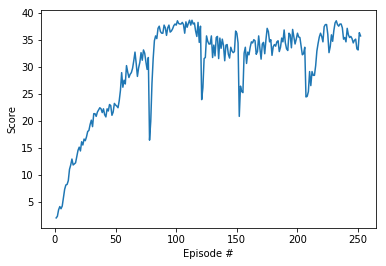

In [55]:
# plot the scores from all the runs
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_from_all_runs)+1), scores_from_all_runs)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Test Trained Agent in the Environment

Once this cell is executed, we can watch the agent's performance.  A window should pop up that allows us to observe the agent, as it moves through the environment. 

In [25]:
#Load the previous trained weights
#Need to turn on the GPU to even test it. Otherwise torch load results in error. 
actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = agent(states, add_noise=False) 
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    steps += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
print('Total steps in this episode: {}'.format(steps))

Total score (averaged over agents) this episode: 35.21199921295047
Total steps in this episode: 1001


When finished, you can close the environment.

In [21]:
env.close()